# Concentrated Solar Power in atlite

## Introduction

In this page we will have a look at how `atlite` can be used to determine the output from CSP (Concentrated Solar Power).
`atlite` currently implements two CSP technologies:

* Parabolic trough
* Solar tower

For both technologies `atlite` can be used to determine the heat output from the heliostat field or solar receiver.
Subsequent steps, e.g. heat storage, electricity conversion and dispatch are not covered by atlite and have to be handled
by an external model.

In [1]:
import atlite
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import yaml
import geopandas as gpd
import pandas as pd

### Technologies
The two technologies are different in the way that they absorb and convert different parts of the direct radiation hitting the surface.

* **Parabolic troughs** only have horizontal tracking of the solar position and thus is modelled to only absorb the **Direct Horizontal Irradiation**, i.e. direct radiation hitting the horizontal plane.
* **Solar tower** heliostats on the other hand require two-axis tracking of the solar position in order to reflect the irradiation into the absorber; this technology is therefore modelled to  absorb the **Direct Normal Irradiation**.

### Installation specific efficiencies and properties

`atlite` uses a simplified approach in modelling CSP. The technology-specific direct irradiation is modified by an efficiency which depends on the local solar position.
The reason for an efficiency which is solar dependend is that a CSP installation can not perfectly absorb all direct irradiation at any given time.

Effects causing less-than-perfect efficiency are e.g.:

* shadowing between rows and adjacents heliostats
* maximum tracking angles
* system design for reduced efficiency during peak irradiation hours in favour of increased efficiency during off-peak sunset/sunrise

The efficiency can be very specific to an CSP installation and its design.
Therefore `atlite` uses the properties of specific CSP installations - similar as for wind turbines or PV panels.
`atlite` ships with these three reference CSP installations:

In [2]:
atlite.cspinstallations.keys()

dict_keys(['lossless_installation', 'SAM_parabolic_trough', 'SAM_solar_tower'])

An installation is characterised by a `dict` of properties

In [3]:
atlite.resource.get_cspinstallationconfig(atlite.cspinstallations.SAM_parabolic_trough)

{'name': 'Parabolic Trough field',
 'source': 'NREL System Advisor Model',
 'technology': 'parabolic trough',
 'r_irradiance': 950,
 'efficiency': <xarray.DataArray 'value' (altitude: 19, azimuth: 73)>
 dask.array<truediv, shape=(19, 73), dtype=float64, chunksize=(19, 73), chunktype=numpy.ndarray>
 Coordinates:
     altitude [deg]  (altitude) int64 dask.array<chunksize=(19,), meta=np.ndarray>
     azimuth [deg]   (azimuth) int64 dask.array<chunksize=(73,), meta=np.ndarray>
   * altitude        (altitude) float64 0.0 0.08727 0.1745 ... 1.396 1.484 1.571
   * azimuth         (azimuth) float64 0.0 0.08727 0.1745 ... 6.109 6.196 6.283,
 'path': PosixPath('/home/pypsa/share/GitHub/atlite/atlite/resources/cspinstallation/SAM_parabolic_trough.yaml')}


Explanation of keys and values:

| key | value | description |
| --- | ----- | ----------- |
| name | str | The installations name. |
| source | str | Source of the installation details. |
| [technology](#technologies) | One of {'parabolic trough', 'solar tower', None}. | Technology to use for this installation. If 'None', technology has to be specified later. |
| r_irradiance | number | Reference irradiance for this installation. Used to calculated capacity factor and maximum output of system. Unit: W/m^2 .|
| [efficiency](#efficiency) | xarray.DataArray | DataArray containing solar position dependend conversion efficiency between Normal Irradiation and thermal output. |
| path | Path | (automatically added) Path the information was loaded from. |


### Efficiency

The efficiencies behaviour of the three installations are quite different

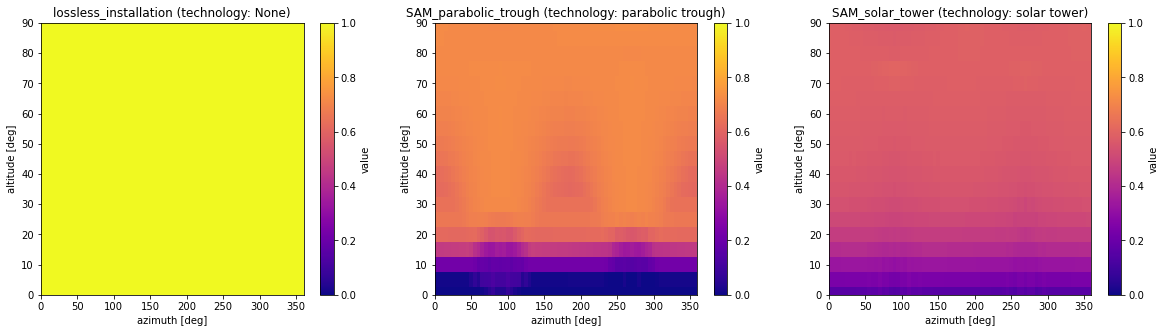

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, name in enumerate(atlite.cspinstallations.keys()):
    config = atlite.resource.get_cspinstallationconfig(atlite.cspinstallations[name])

    config["efficiency"].plot(
        x="azimuth [deg]",
        y="altitude [deg]",
        cmap="plasma",
        ax=axes[i],
        vmin=0,
        vmax=1.0,
    )
    axes[i].set_title(f'{name} (technology: {config["technology"]})')
    axes[i].set_xlim(0, 360)
    axes[i].set_ylim(0, 90)

For the two 'SAM_*' models the efficiency strongly depends on the solar azimuth and altitude.
Due to the installations' specifics, no efficiency is defined for high solar azimuth positions.
These installations may therefore not be suited for locations with high solar azimuths.
Both models also have technologies predefined, such that the 'technology' parameter does not need to be supplied during handling.
The installation details for 'SAM_parabolic_trough' and 'SAM_solar_tower' were retrieved and modelled with NREL's System Advisor Model.
For details on the process see [the section below](#extracting-efficiencies-from-sam).

The 'lossless_installation' is an universal installation which has by default perfect efficiency and is thus able to convert the direct irradiation of either technology into an heat output.
It can be used to easily create fixed-efficiency installations, e.g. an installation with solar to heat efficiency of 65% may be created as follows:

In [5]:
# Load installation configuration by
config = atlite.resource.get_cspinstallationconfig("lossless_installation")
# or
config = atlite.resource.get_cspinstallationconfig(
    atlite.cspinstallations.lossless_installation
)

# Reduce efficiency to 65%
config["efficiency"] *= 0.65

## Resource evaluation

To evaluate the resources and suitability of locations for CSP, we first need to [create an cutout](https://atlite.readthedocs.io/en/latest/examples/create_cutout.html) for the area of interest:

In [6]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
spain = world.query('name == "Spain"')

cutout = atlite.Cutout(
    path="spain_2017_era5.nc",
    module="era5",
    bounds=spain.iloc[0].geometry.bounds,
    time="2017",
)

cutout.prepare(["influx"])

/home/pypsa/share/GitHub/atlite/atlite/cutout.py:186: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<Cutout "spain_2017_era5">
 x = -9.25 ⟷ 3.00, dx = 0.25
 y = 36.00 ⟷ 43.50, dy = 0.25
 time = 2017-01-01 ⟷ 2017-12-31, dt = H
 module = era5
 prepared_features = ['influx']

### Capacity factor

We can then calculate the capacity factor for each grid cell by specifying an installation and (if not included in the installation configuration) a 'technology':

In [7]:
cf = cutout.csp(installation="SAM_solar_tower", capacity_factor=True)

[########################################] | 100% Completed |  2.1s


Text(0.5, 0.98, 'CSP capacity factor')

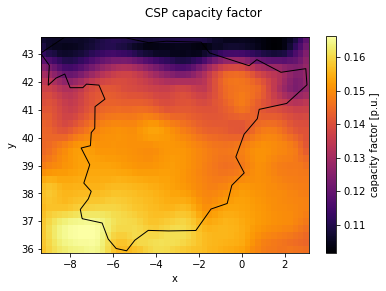

In [8]:
# Plot capacity factor with Spain shape overlay
fig, ax = plt.subplots()
cf.plot(cmap="inferno", ax=ax)
spain.plot(fc="None", ec="black", ax=ax)
fig.suptitle("CSP capacity factor")

Alternatively the specific generation can be calculated by setting `capacity_factor=False` (default).
An comparison between the `SAM_solar_tower` installation and `lossless_installation` shows the difference due to the solar position dependend efficiency:

We take as comparison an existing installation of a Solar Tower, the [PS10 in Spain](https://en.wikipedia.org/wiki/PS10_solar_power_plant)

In [9]:
# Calculation of Capacity Factor and Specific Generation for: SAM_solar_tower installation
st = {
    "capacity factor": cutout.csp(
        installation="SAM_solar_tower", capacity_factor=True
    ).rename("SAM_solar_tower CF"),
    "specific generation": cutout.csp(installation="SAM_solar_tower").rename(
        "SAM_solar_tower SG"
    ),
}

# Calculation of Capacity Factor and Specific Generation for: lossless solar tower installation
ll = {
    "capacity factor": cutout.csp(
        installation="lossless_installation",
        technology="solar tower",
        capacity_factor=True,
    ).rename("lossless_installation CF"),
    "specific generation": cutout.csp(
        installation="lossless_installation",
        technology="solar tower",
    ).rename("lossless_installation SG"),
}

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s


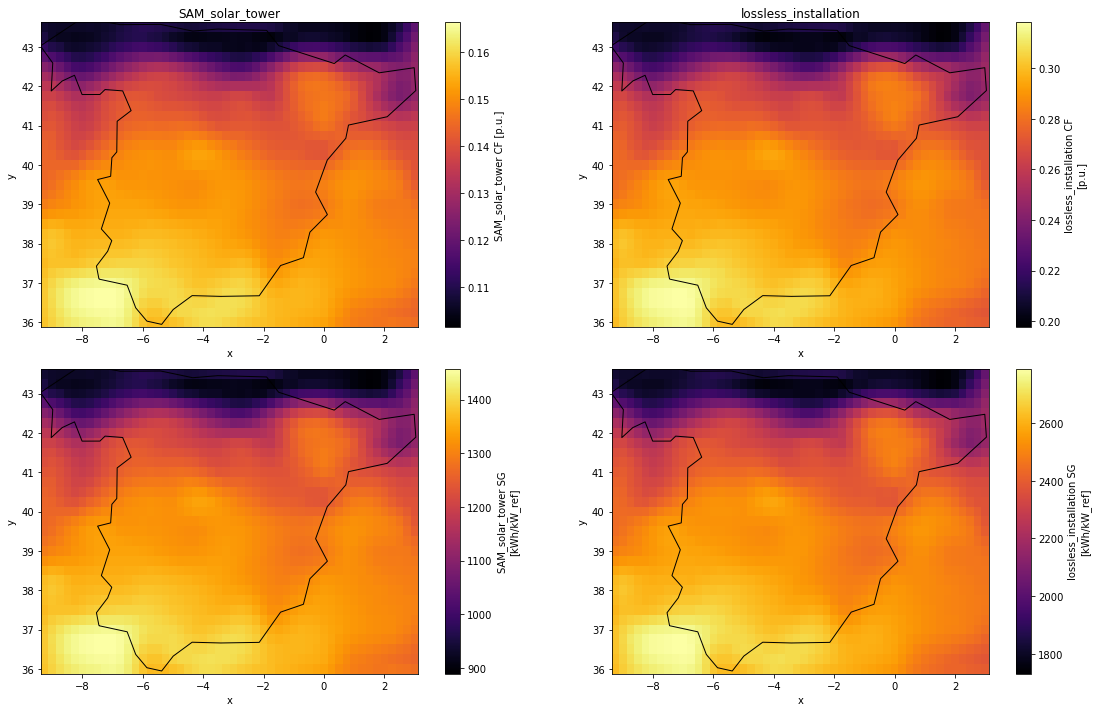

In [10]:
# Plot results side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

st["capacity factor"].plot(ax=axes[0][0], cmap="inferno")
st["specific generation"].plot(ax=axes[1][0], cmap="inferno")
axes[0][0].set_title("SAM_solar_tower")

ll["capacity factor"].plot(ax=axes[0][1], cmap="inferno")
ll["specific generation"].plot(ax=axes[1][1], cmap="inferno")
axes[0][1].set_title("lossless_installation")

# Overlay Spainish borders
for ax in axes.ravel():
    spain.plot(ax=ax, fc="none", ec="black")

fig.tight_layout()

### Capacity layout for a specific location

We take as comparison an existing installation of a Solar Tower, the [PS10 in Spain](https://en.wikipedia.org/wiki/PS10_solar_power_plant):

In [11]:
# Layout with different installed capacity (due to different SAM model)
config = atlite.resource.get_cspinstallationconfig("SAM_solar_tower")
# solar field: 624 mirrors with 120m^2 each
area = 624 * 120  # 74880 m^2

# installed power = 950 W/m^2 * area = 90.2 MW
installed_power = config["r_irradiance"] * area / 1.0e6


# actual PS10 location
# see https://geohack.toolforge.org/geohack.php?pagename=PS10_solar_power_plant&params=37_26_32_N_06_15_15_W_type:landmark_region:ES
location = {"x": -6.254167, "y": 37.442222}

# Determine location on cutout grid
nearest_location = {
    v: cutout.grid[v].iloc[cutout.grid[v].sub(location[v]).abs().idxmin()]
    for v in ["x", "y"]
}

layout = xr.zeros_like(cf)
layout.loc[dict(x=nearest_location["x"], y=nearest_location["y"])] = installed_power

Text(0.5, 0.98, 'Layout with PS10')

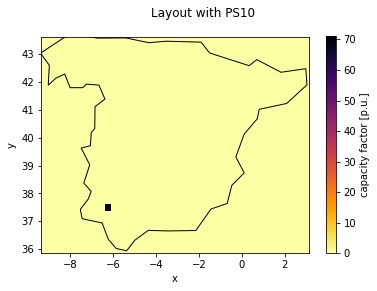

In [12]:
# Plot layout with  Spain shape overlay
fig, ax = plt.subplots()
layout.plot(cmap="inferno_r", ax=ax)
spain.plot(fc="None", ec="black", ax=ax)
fig.suptitle("Layout with PS10")

### Solar tower: Hourly time-series and monthly output

In [13]:
# Calculate time-series for layout with both installation configurations
time_series = xr.merge(
    [
        cutout.csp(
            installation="lossless_installation",
            technology="solar tower",
            layout=layout,
        ).rename("lossless_installation"),
        cutout.csp(installation="SAM_solar_tower", layout=layout).rename(
            "SAM_solar_tower"
        ),
    ]
)

# Load reference time-series from file
df = pd.read_csv("../profiles_and_efficiencies_from_sam/ST-salt_time-series_spain.csv")
df["time"] = time_series["time"].values + pd.Timedelta(
    1, unit="h"
)  # account for reference values in UTC-1 instead of UTC
df = df.set_index("time")
df = df["Estimated receiver thermal power TO HTF | (MWt)"] * (
    # Rescale: Simulation in SAM uses solar field of 1 269 054 m^2 and 950 W/m^2 reference irradiation = 1 205.6 MW
    installed_power
    / (950 * 1269054 / 1e6)
)
time_series["NREL SAM"] = df.to_xarray()

time_series = time_series.squeeze().drop("dim_0")  # Remove excess dimension

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s


Text(0.5, 1.0, 'Example output time-series')

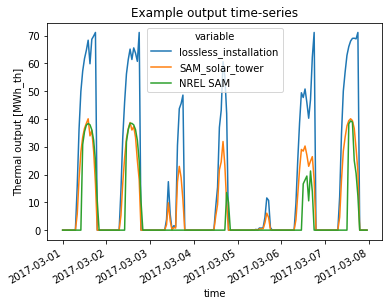

In [14]:
time_series.to_array().sel(time=slice("2017-03-01", "2017-03-07")).plot.line(
    x="time", hue="variable"
)

plt.ylabel("Thermal output [MWh_th]")
plt.title("Example output time-series")

From the figure above the difference between perfect efficiency ('lossless_installation') and solar position dependend conversion efficiency ('SAM_solar_tower') can be seen.
Mostly for low solar altitudes (where the DNI calculation may overestimate DNI due to cosine errors), the imperfect efficiency shows a smoother generation profile than the perfect installation.

The 'reference' data included in the figure shows the output of the more sophisticated SAM CSP model for the same location and installation.
In general a qualitatively acceptable fit is achieved with the simplified approach used in `atlite`.

Looking at the monthly energy output we see an approximate match between the `atlite` and reference results:

Text(0.5, 1.0, 'Monthly output')

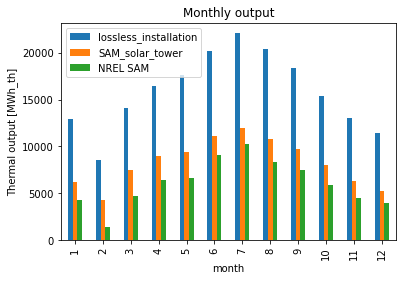

In [15]:
time_series.groupby("time.month").sum().to_dataframe().plot.bar()
plt.ylabel("Thermal output [MWh_th]")
plt.title("Monthly output")

### Differences between NREL's SAM and atlite output

Differences between the `atlite` results and more sophisticated SAM reference model can be due to a multitude of effects, e.g.:

* The reference model uses weather data from the National Solar Radiation Database (NSRDB), the simulated results from atlite use ERA5 data. NSRDB relies on a physical model which combines satellite data with reanalysis data, compared to ERA5 which is a pure reanalysis dataset.
* `atlite` uses an simple approach to determining DNI for solar tower heliostat fields
* The `reference` data against which the `atlite` output is compared against reflects the thermal HTF (heat transfer fluid) output; the `atlite` numbers on the other hand reflect the absorbed thermal energy
* The reference model accounts for wind velocities and necessary heliostat stowing
* The reference model takes maintenance and cleaning outages into account
* The reference model can reduce heliostat performance due to dispatch reasons

### Parabolic trough: Hourly time-series and monthly output

The issues of overestimating direct irradiation does not occur with `technology=parabolic trough`, in which case an DNI esimation is not necessary and `atlite` can directly rely on DHI retrieved from the cutout's dataset.
The following calculation and figure show this using a fictive parabolic trough CSP plant in the same location as the PS10 plant from above:

In [16]:
# Layout with different installed capacity (due to different SAM model)
config = atlite.resource.get_cspinstallationconfig("SAM_parabolic_trough")
# solar field size in m^2 of fictive plant
area = 881664

# installed power = 950 W/m^2 * area = 1205.0 MW
installed_power = config["r_irradiance"] * area / 1.0e6
layout.loc[dict(x=nearest_location["x"], y=nearest_location["y"])] = installed_power

# Calculate time-series for layout with both installation configurations
time_series = xr.merge(
    [
        cutout.csp(
            installation="lossless_installation",
            technology="parabolic trough",
            layout=layout,
        ).rename("lossless_installation"),
        cutout.csp(installation="SAM_parabolic_trough", layout=layout).rename(
            "SAM_parabolic_trough"
        ),
    ]
)

# Load reference time-series from file
df = pd.read_csv("../profiles_and_efficiencies_from_sam/PT-physical_time-series_spain.csv")
# account for reference values in UTC-1 instead of UTC
df["time"] = time_series["time"].values + pd.Timedelta(1, unit="h")

df = df.set_index("time")
df = df["Estimate rec. thermal power TO HTF | (MWt)"]
time_series["NREL SAM"] = df.to_xarray()

time_series = time_series.squeeze().drop("dim_0")  # Remove excess dimension

[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.1s


Text(0.5, 1.0, 'Example output time-series')

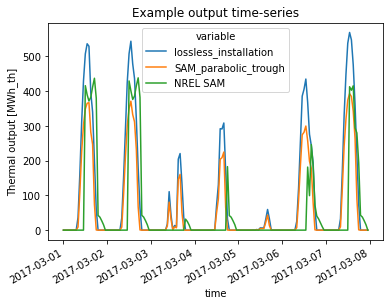

In [17]:
time_series.to_array().sel(time=slice("2017-03-01", "2017-03-07")).plot.line(
    x="time", hue="variable"
)
plt.ylabel("Thermal output [MWh_th]")
plt.title("Example output time-series")

For `technology="parabolic trough"`  the monthly output is also better:

Text(0.5, 1.0, 'Monthly output')

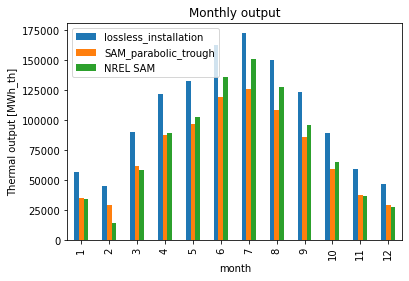

In [18]:
time_series.groupby("time.month").sum().to_dataframe().plot.bar()
plt.ylabel("Thermal output [MWh_th]")
plt.title("Monthly output")

## ERA5 vs. SARAH2 data

Next to ERA5 data, SARAH2 data can also be used as the underpinning `cutout` data.
SARAH2 is generally considered more accurate for radiation products as it uses satellite data.

In [19]:
# Create cutout using SARAH data
cutout_sarah = atlite.Cutout(
    path="spain_2017_sarah.nc",
    module="sarah",
    bounds=spain.iloc[0].geometry.bounds,
    time="2017",
)

# Save space and computing time: only need the influx feature for demonstration
cutout_sarah.prepare(features=["influx"])

/home/pypsa/share/GitHub/atlite/atlite/cutout.py:186: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<Cutout "spain_2017_sarah">
 x = -9.25 ⟷ 3.00, dx = 0.25
 y = 36.00 ⟷ 43.50, dy = 0.25
 time = 2017-01-01 ⟷ 2017-12-31, dt = H
 module = sarah
 prepared_features = ['influx']

In [20]:
# Calculate time-series for layout with both installation configurations
time_series = xr.merge(
    [
        cutout_sarah.csp(installation="SAM_parabolic_trough", layout=layout).rename(
            "SARAH"
        ),
        cutout.csp(
            installation="SAM_parabolic_trough",
            layout=layout,
        ).rename("ERA5"),
    ]
)

# Load reference NREL SAM time-series from file
df = pd.read_csv("../profiles_and_efficiencies_from_sam/PT-physical_time-series_spain.csv")

# account for reference values in UTC-1 instead of UTC
df["time"] = time_series["time"].values + pd.Timedelta(1, unit="h")

df = df.set_index("time")
df = df["Estimate rec. thermal power TO HTF | (MWt)"]
time_series["NREL SAM"] = df.to_xarray()

time_series = time_series.squeeze().drop("dim_0")  # Remove excess dimension

[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  2.2s


Text(0.5, 1.0, 'Example output time-series')

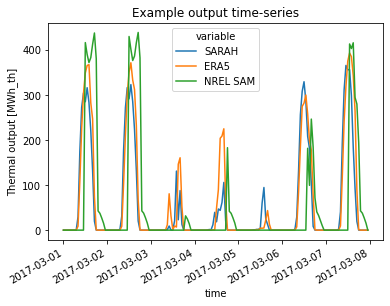

In [21]:
time_series.to_array().sel(time=slice("2017-03-01", "2017-03-07")).plot.line(
    x="time", hue="variable"
)
plt.ylabel("Thermal output [MWh_th]")
plt.title("Example output time-series")

In the monthly aggregated output it can be seen that the SARAH dataset has a lower overestimation error compared to the ERA5 dataset.

Text(0.5, 1.0, 'Monthly output')

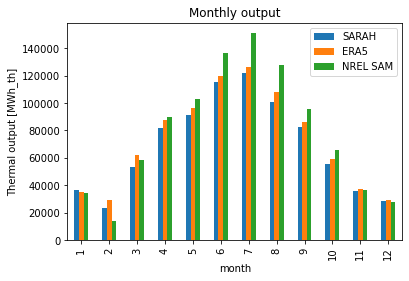

In [22]:
time_series.groupby("time.month").sum().to_dataframe().plot.bar()
plt.ylabel("Thermal output [MWh_th]")
plt.title("Monthly output")

Neither dataset (ERA5 and SARAH) are replicating the generation output of a singular, specific plant modelled with NREL's SAM using NSRDB data.
`atlite` generally is not designed with modelling generation output of singular plants.
Rather `atlite` is meant to be used to assess the ressources of a larger geographic extent for potential CSP output.

We end this comparison with a sometimes used, very simple approach of only using the DNI time-series to model the CSP generation.
Compared on a monthly basis the `atlite` output is closer to the NREL SAM reference model.
For time-series output one can compare the time-series of the "lossless" plant configuration shown earlier.
Generally, the qualitative modelling performance of this approach is poorer compared to the `atlite` or `SAM` methods.

Text(0.5, 1.0, 'Monthly output')

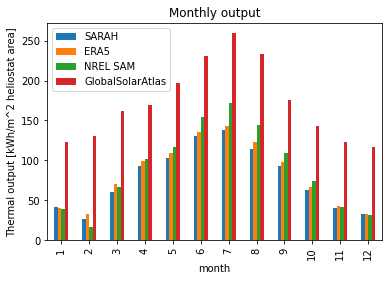

In [23]:
# Monthly average DNI data for a TMY from GlobalSolarAtlas
# URL: https://globalsolaratlas.info/detail?s=37.5,-6.3&m=site&c=33.583674,-10.898438,3 (accessed: 2021-11-22)
df = pd.DataFrame(
    [122.5, 131, 161.9, 169.1, 197.1, 230.3, 259.6, 232.8, 175.3, 142.7, 122.8, 116.6],
    index=pd.Index(np.arange(1, 13, 1), name="month"),
    columns=["GlobalSolarAtlas"],
)

ds = time_series.groupby("time.month").sum() / area * 1e3  # in kWh/m^2

ds = ds.to_dataframe()

ds["GlobalSolarAtlas"] = df["GlobalSolarAtlas"]

ds.plot.bar()
plt.ylabel("Thermal output [kWh/m^2 heliostat area]")
plt.title("Monthly output")

## Extracting efficiencies from SAM

Instead of implementing a detailed physical model for CSP plants in `atlite` an approach was selected where an efficiency map is handed over to `atlite` for simulating the conversion efficiency and processes inside the solar field of an CSP plant.
The efficiency maps which come with `atlite` were created using [NREL's System Advisor Model](https://sam.nrel.gov/), which allows for a detailed specification and simulation of CSP plants (solar tower and parabolic trough).

The hourly solar field efficiencies and solar positions were then exported to a `.csv` file.
Using this import, the efficiency maps for `atlite` were then created.
In the following these steps are shown and the output is compared to the input from SAM.

In [24]:
# Read SAM output: Hourly solar field efficiency and solar positions
df = pd.read_csv("../profiles_and_efficiencies_from_sam/PT-physical.csv")

df = df.rename(
    columns={
        "Hourly Data: Resource Solar Azimuth (deg)": "azimuth",
        "Hourly Data: Resource Solar Zenith (deg)": "zenith (deg)",
        "Hourly Data: Field optical efficiency before defocus": "efficiency",
    }
)

# Convert solar zenith to solar altitude
df["altitude"] = 90 - df["zenith (deg)"]

# Only non-zero entries from hourly data are relevant
df = df[df["efficiency"] > 0.0]

# Efficiency in %, avoids dropping significant places in round(1) later
df["efficiency"] *= 100

# Reduce noise in solar position by rounding each position to 2°
# Creates a lot of duplicates
base = 2

df[["azimuth", "altitude"]] = (df[["azimuth", "altitude"]] / base).round(0) * base

# Drop duplicates: Keep only highest efficiency per position
df = df.groupby(["altitude", "azimuth"]).max()

# Drop all columns except for efficiency
df = df[["efficiency"]]

da = df.to_xarray()["efficiency"]

# Interpolate values to a finer grid and fill missing values by extrapolation
# Order is relevant: Start with Azimuth (where we have sufficient values) and then continue with altitude
da = (
    da.interpolate_na("azimuth")
    .interpolate_na("altitude")
    .interpolate_na("azimuth", fill_value="extrapolate")
)

# Use rolling horizon to smooth values, average over 3x3 adjacent values per pixel
da = (
    da.rolling(azimuth=3, altitude=3)
    .mean()
    .interpolate_na("altitude", fill_value="extrapolate")
    .interpolate_na("azimuth", fill_value="extrapolate")
)

# Create second dataset, mirrored around 90° (covering 90° to -90° with same numbers)
da = da.sel(azimuth=slice(90,270))
da_new = da.assign_coords(azimuth=(((da.azimuth-180)*(-1))%360)).sortby('azimuth')
da = xr.merge([da, da_new])['efficiency']

# Reduce resolution to coarser grid for reduced storage footprint
interpolation_step = 5
da = da.interp(
    azimuth=np.arange(da["azimuth"].min(), da["azimuth"].max(), interpolation_step),
    altitude=np.arange(0, 91, interpolation_step),
    kwargs={"fill_value": "extrapolate"},
).clip(min=0.0)

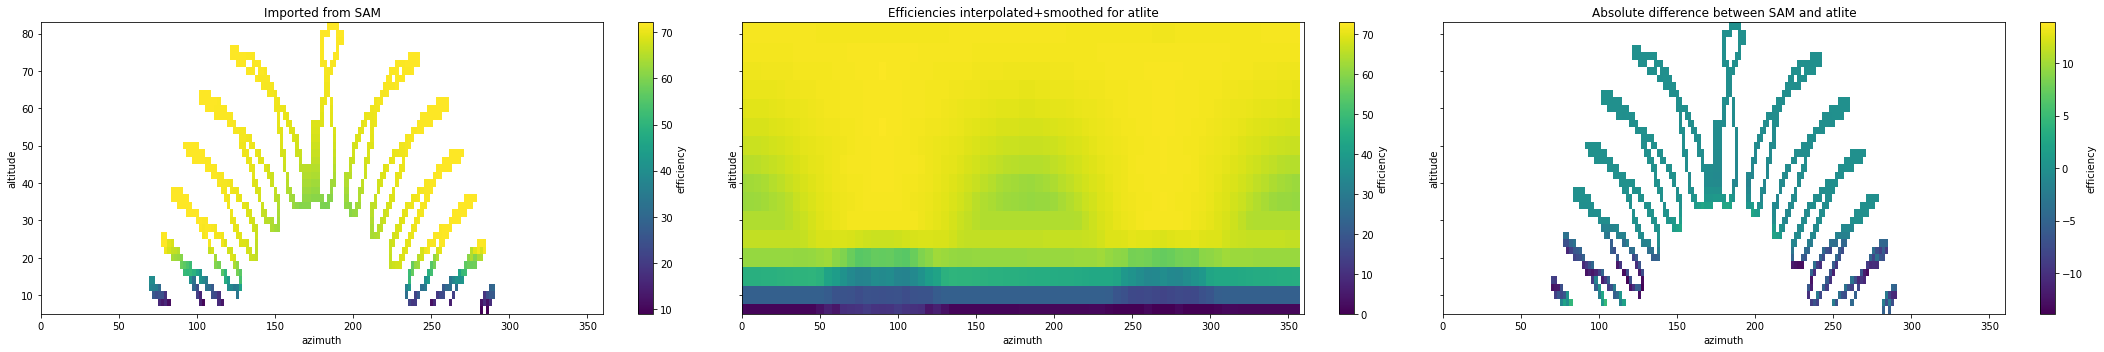

In [25]:
# Plot efficiencies against each other
fig, axes = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(30, 5))

ax = axes[0]
df.to_xarray()["efficiency"].plot(cmap="viridis", ax=ax)
ax.set_title("Imported from SAM")
ax.set_xlim(0,360)

ax = axes[1]
da.plot(cmap="viridis", ax=ax)
ax.set_title("Efficiencies interpolated+smoothed for atlite")
ax.set_xlim(0,360)

ax = axes[2]
((da.interp_like(df.to_xarray()) - df.to_xarray()["efficiency"])).plot(
    cmap="viridis", ax=ax
)
ax.set_title("Absolute difference between SAM and atlite")
ax.set_xlim(0,360)

fig.tight_layout()

The differences between the original efficiency map from SAM and the derived efficiency map for atlite are low, in most cases below 1%.
The efficiency map is then written to a `.yaml` file, combined with the remaining installation information for the specific CSP plant (also taken from SAM)

In [26]:
df = da.to_dataframe().reset_index()
df = df.rename(columns={"efficiency": "value"})
df[["altitude", "azimuth"]] = df[["altitude", "azimuth"]].astype(int)
df = df.to_dict("dict")

config = {
    "name": "Parabolic Trough field",
    "source": "NREL System Advisor Model",
    "technology": "parabolic trough",
    "r_irradiance": 950,  # W/m2,
    "efficiency": df,
}

with open("SAM_solar_tower.yaml", "w") as f:
    yaml.safe_dump(config, f, default_flow_style=False, sort_keys=False)